In [33]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textblob import TextBlob
import re
import spacy
from sklearn.pipeline import Pipeline
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [34]:
df = pd.read_csv('./csv/train_tweets.csv')

In [35]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
nombre_doublons = df['text'].duplicated().sum()
print(f"Doublons dans la colonne 'text' du DataFrame : {nombre_doublons}")

df = df.drop_duplicates(subset='text', keep='first')

Doublons dans la colonne 'text' du DataFrame : 110


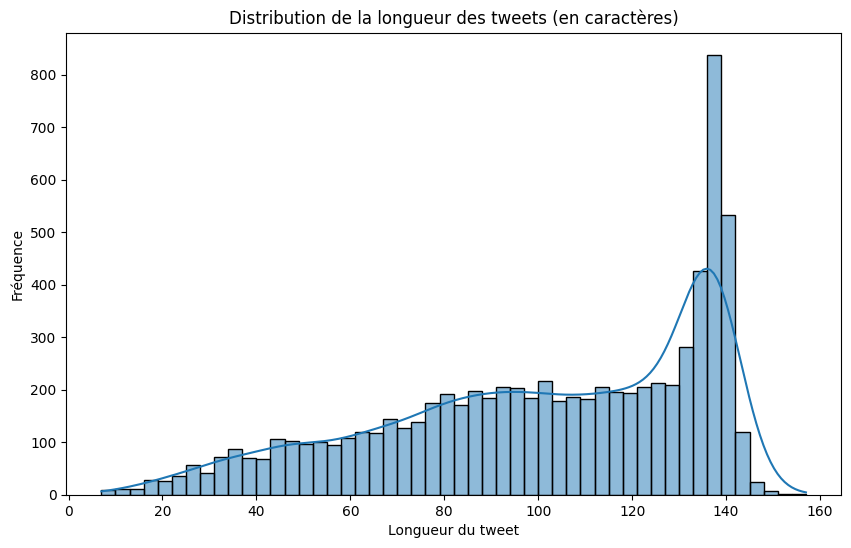

In [37]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

Ce graphique illustre la distribution de la longueur des tweets mesurée en caractères :

Axe des Abscisses (X) : Longueur des tweets en caractères. Axe des Ordonnées (Y) : Fréquence des tweets pour chaque longueur. Observations

Forme de la Distribution :

Les tweets augmentent progressivement en longueur jusqu'à un pic significatif à 140 caractères. La majorité des tweets se situent entre 20 et 140 caractères. Pic Principal :

Le pic se trouve autour de 140 caractères, indiquant que de nombreux utilisateurs maximisent la longueur autorisée des tweets. Densité de la Distribution :

La courbe KDE montre une estimation lissée, confirmant que 140 caractères est la longueur la plus courante. Ce graphique montre que les utilisateurs tendent à utiliser la totalité de l'espace disponible pour leurs tweets.

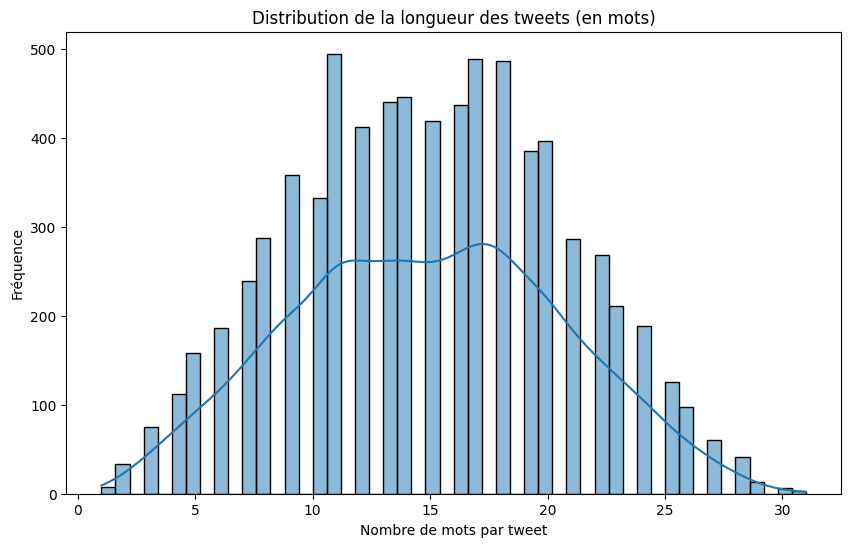

In [38]:
# Distribution de la longueur des tweets (en mots)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en mots)')
plt.xlabel('Nombre de mots par tweet')
plt.ylabel('Fréquence')
plt.show()

Ce graphique illustre la distribution de la longueur des tweets mesurée en nombre de mots :

Axe des Abscisses (X) : Nombre de mots par tweet. Axe des Ordonnées (Y) : Fréquence des tweets pour chaque nombre de mots. Observations

Forme de la Distribution :

La distribution montre une augmentation progressive du nombre de tweets jusqu'à environ 15 mots, suivie d'une diminution. Les tweets les plus courants contiennent entre 10 et 20 mots. Pic Principal :

Le pic se trouve autour de 15 mots, indiquant que la majorité des tweets sont assez courts mais expressifs. Densité de la Distribution :

La courbe KDE montre une estimation lissée de la densité de probabilité, confirmant que 15 mots est la longueur la plus courante pour les tweets. Ce graphique montre que la plupart des utilisateurs tendent à rédiger des tweets concis mais informatifs, généralement entre 10 et 20 mots.

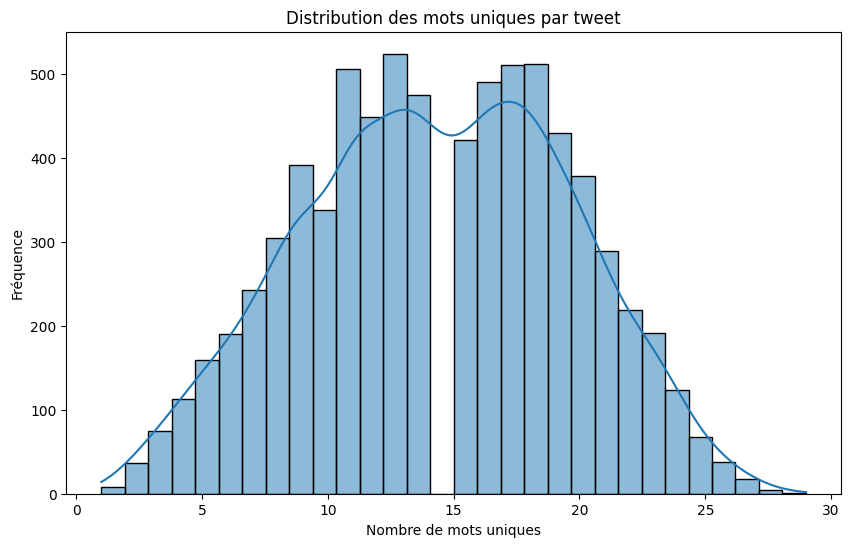

In [39]:
# Distribution des mots uniques par tweet
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(10, 6))
sns.histplot(df['unique_words'], bins=30, kde=True)
plt.title('Distribution des mots uniques par tweet')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Fréquence')
plt.show()

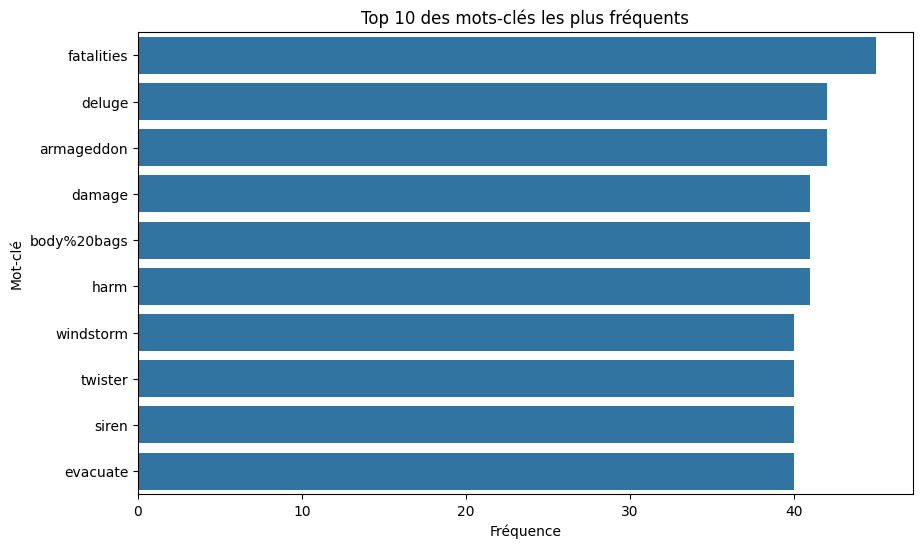

In [40]:
# Distribution des mots-clés (keywords)
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', data=df, order=df['keyword'].value_counts().iloc[:10].index)
plt.title('Top 10 des mots-clés les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Mot-clé')
plt.show()

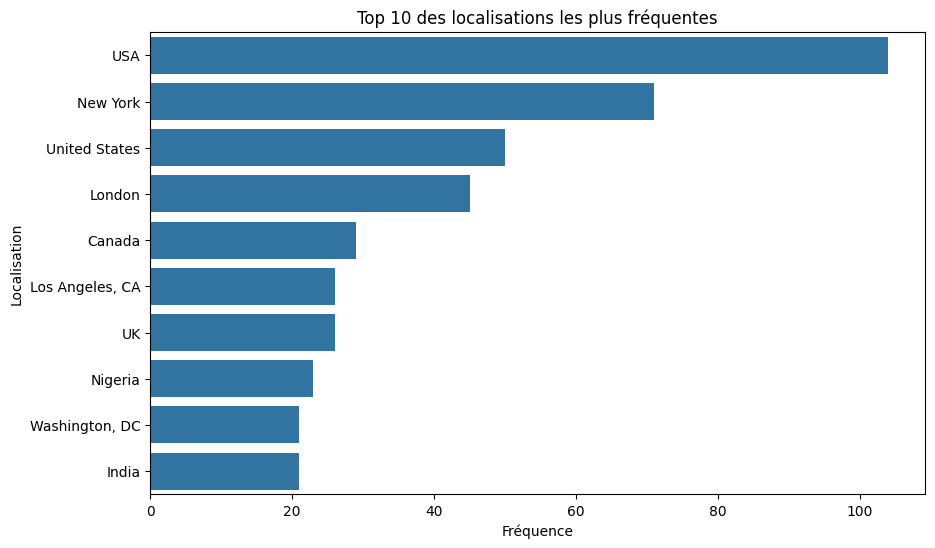

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', data=df, order=df['location'].value_counts().iloc[:10].index)
plt.title('Top 10 des localisations les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Localisation')
plt.show()

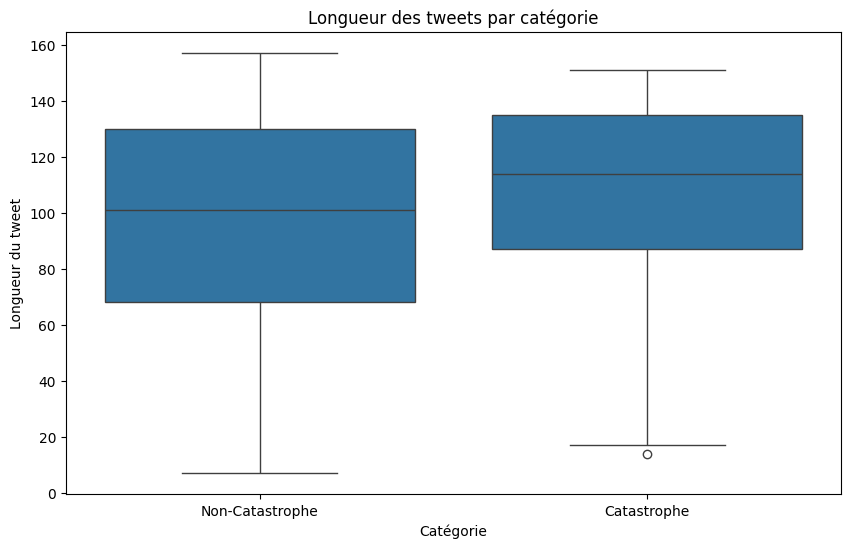

In [42]:
# Boxplot des longueurs de tweets par catégorie
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=df['text'].apply(len), data=df)
plt.title('Longueur des tweets par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Longueur du tweet')
plt.xticks([0, 1], ['Non-Catastrophe', 'Catastrophe'])
plt.show()


Ce graphique montre la distribution de la longueur des tweets pour les catégories "Catastrophe" et "Non-Catastrophe" à l'aide de violins plots :

Axe des Abscisses (X) : Catégorie du tweet (Non-Catastrophe ou Catastrophe). Axe des Ordonnées (Y) : Longueur des tweets en caractères. Observations

Distribution Générale :

La distribution des longueurs de tweets est similaire pour les deux catégories. Les tweets ont une large gamme de longueurs, allant de très courts à la limite maximale de caractères. Comparaison entre Catégories :

Les tweets de catastrophes et non catastrophiques ont des médianes de longueur similaires. Les tweets de catastrophes semblent légèrement plus longs en moyenne. Forme des Distributions :

Les deux distributions présentent une densité plus élevée autour de 100-140 caractères.

C:\Users\aurel\AppData\Local\Temp\ipykernel_15044\1457864944.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index,palette='coolwarm', edgecolor='black')


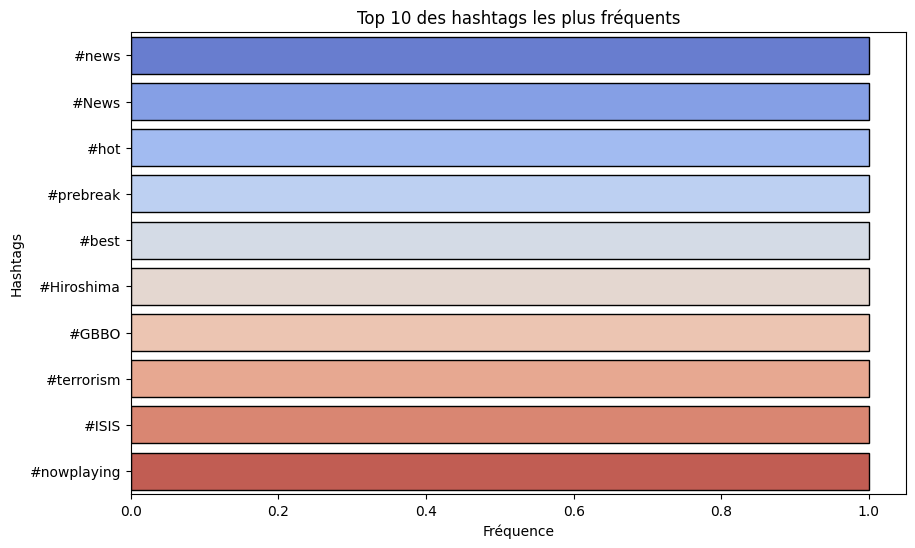

In [43]:
# Extraire les hashtags et mentions
df['hashtags'] = df['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
df['mentions'] = df['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

# Flatten la liste des hashtags et mentions
all_hashtags = df['hashtags'].explode().dropna()
all_mentions = df['mentions'].explode().dropna()

plt.figure(figsize=(10, 6))
all_hashtags = all_hashtags[~all_hashtags.str.contains(r'^\W+$')]
hashtag_counts = all_hashtags.value_counts()

sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index,palette='coolwarm', edgecolor='black')
plt.title('Top 10 des hashtags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Hashtags')
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_15044\1613299730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


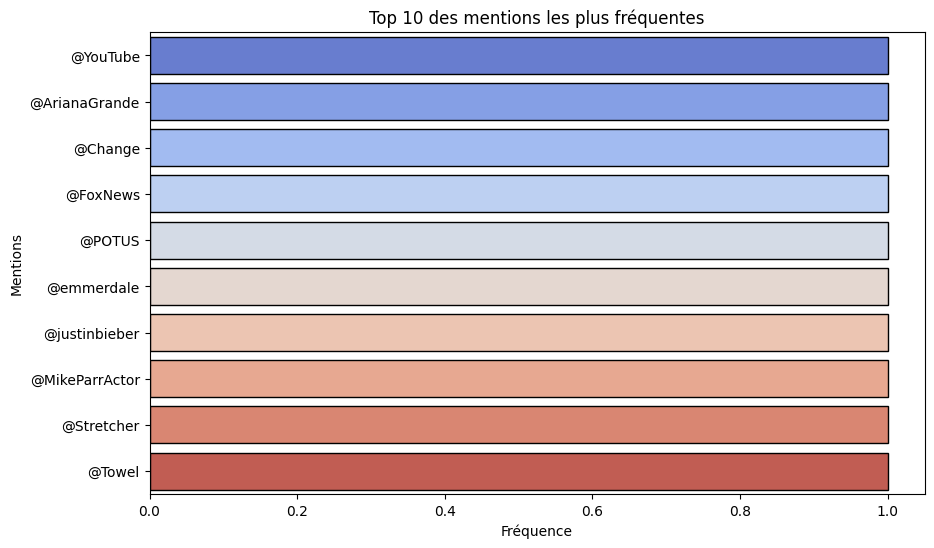

In [44]:
plt.figure(figsize=(10, 6))
all_mentions = all_mentions[all_mentions.str.contains(r'[a-zA-Z0-9]')]

mention_counts = all_mentions.value_counts()
sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des mentions les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Mentions')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


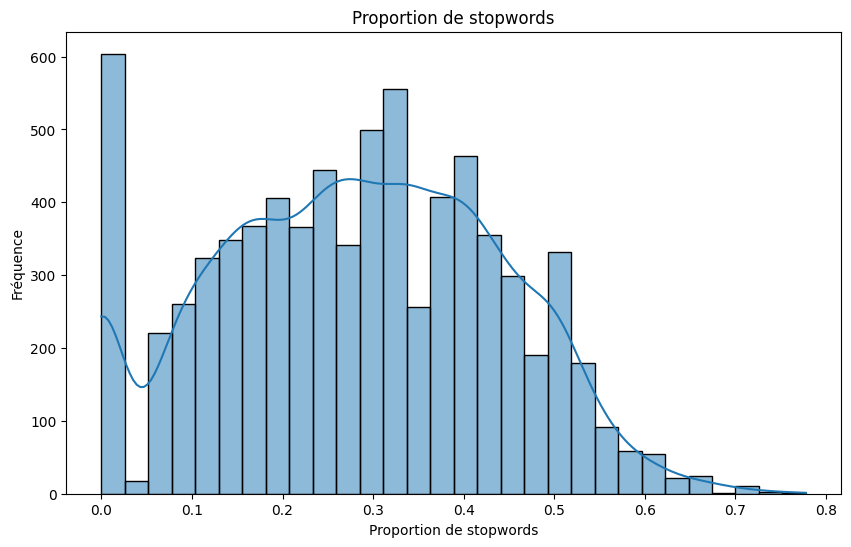

In [45]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Calculer le pourcentage de stopwords dans chaque tweet
df['stopword_percentage'] = df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]) / len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['stopword_percentage'], bins=30, kde=True)
plt.title('Proportion de stopwords')
plt.xlabel('Proportion de stopwords')
plt.ylabel('Fréquence')
plt.show()

Proportion de Stopwords par Tweet
Ce graphique représente la proportion de stopwords (mots vides) dans chaque tweet. Les stopwords sont des mots très courants qui n'apportent pas de valeur significative à l'analyse du texte, tels que "le", "et", "mais", etc.

Observations
Distribution Générale :

La distribution montre une variété de proportions de stopwords dans les tweets.
La plupart des tweets ont une proportion de stopwords entre 10% et 50%.
Pic à 0% :

Il y a un pic notable à 0%, indiquant que certains tweets ne contiennent aucun stopword. Cela peut être dû à des tweets très courts ou à des tweets composés principalement de hashtags, mentions ou mots techniques.
Tendance Générale :

La distribution semble avoir des pics autour de 10% et 30% de stopwords.
Il y a une décroissance progressive des tweets avec une proportion de stopwords supérieure à 50%.

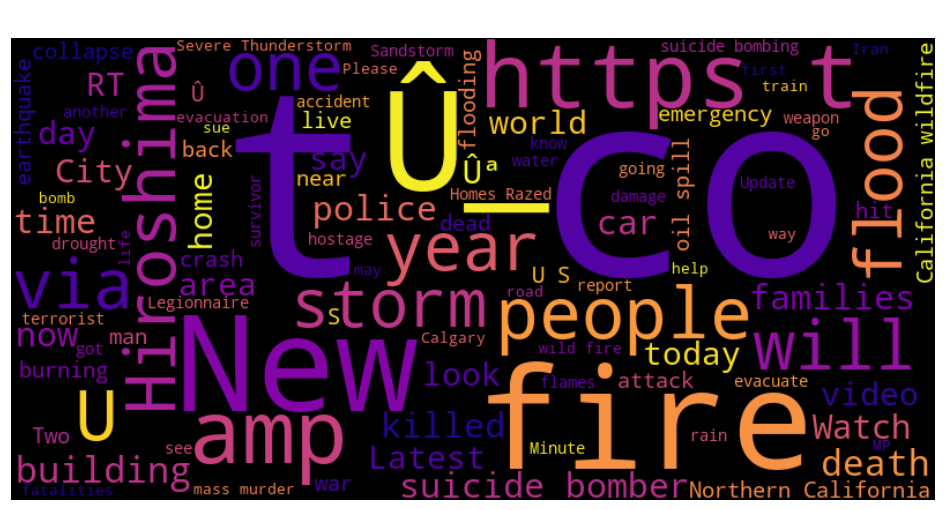

In [46]:
disaster_tweets_train = df[df['target'] == 1]['text'].values
wordcloud_train = WordCloud(
    width=800,
    height=400,
    background_color='black',
    stopwords=STOPWORDS,
    colormap='plasma',
    max_words=100,
    contour_color='white',
    contour_width=1
).generate(' '.join(disaster_tweets_train))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots pour les tweets de catastrophes - Dataset d\'Entraînement', fontsize=18, color='white')
plt.show()


Les nuages de mots permettent de visualiser rapidement les termes les plus courants dans les tweets de catastrophes, aidant à identifier les thèmes et sujets récurrents.

En montrant quels mots sont les plus fréquents, les nuages de mots aident à orienter l'analyse exploratoire en mettant en évidence les termes importants qui pourraient nécessiter une attention particulière.

Ils peuvent révéler des mots courants ou des expressions qui pourraient être ajoutés à la liste des stopwords pour affiner les modèles de traitement du langage naturel (NLP).

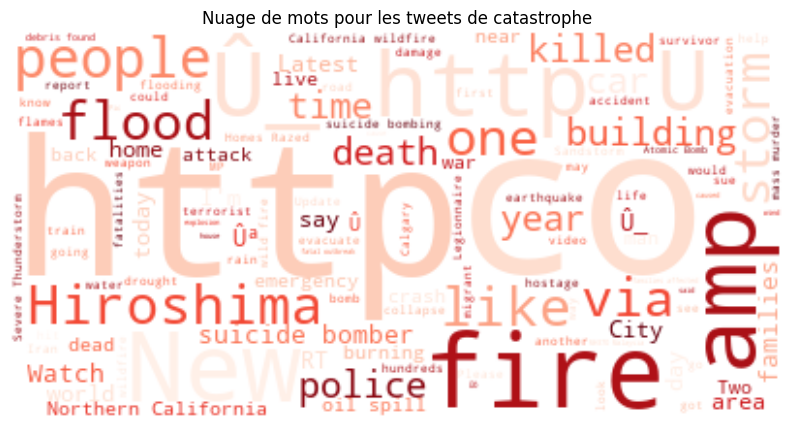

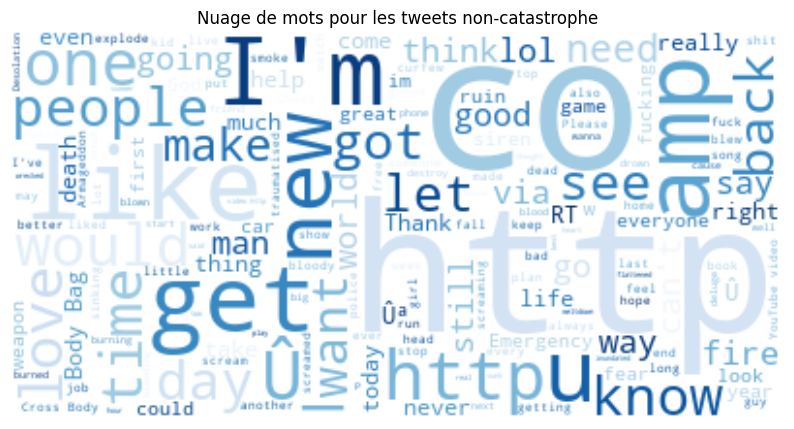

In [47]:
# Nuage de mots pour les tweets de catastrophe
disaster_tweets = ' '.join(df[df['target'] == 1]['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap='Reds').generate(disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuage de mots pour les tweets de catastrophe')
plt.axis('off')
plt.show()

# Nuage de mots pour les tweets non-catastrophe
non_disaster_tweets = ' '.join(df[df['target'] == 0]['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap='Blues').generate(non_disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuage de mots pour les tweets non-catastrophe')
plt.axis('off')
plt.show()

Analyse du Dataset de Test  
Pour le dataset de test, nous allons appliquer les mêmes analyses et visualisations que pour le dataset d'entraînement afin de comparer les distributions et les corrélations. Étant donné que les types de graphiques et les observations seront similaires, nous ne répéterons pas les explications détaillées pour chaque graphique. Cependant, les différences significatives seront mises en évidence.

Double-cliquez (ou appuyez sur Entrée) pour modifier

In [48]:
df_test = pd.read_csv('./csv/test_tweets.csv')

In [49]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [50]:
nombre_doublons = df_test['text'].duplicated().sum()
print(f"Doublons dans la colonne 'text' du DataFrame : {nombre_doublons}")

df_test = df_test.drop_duplicates(subset='text', keep='first')

Doublons dans la colonne 'text' du DataFrame : 20


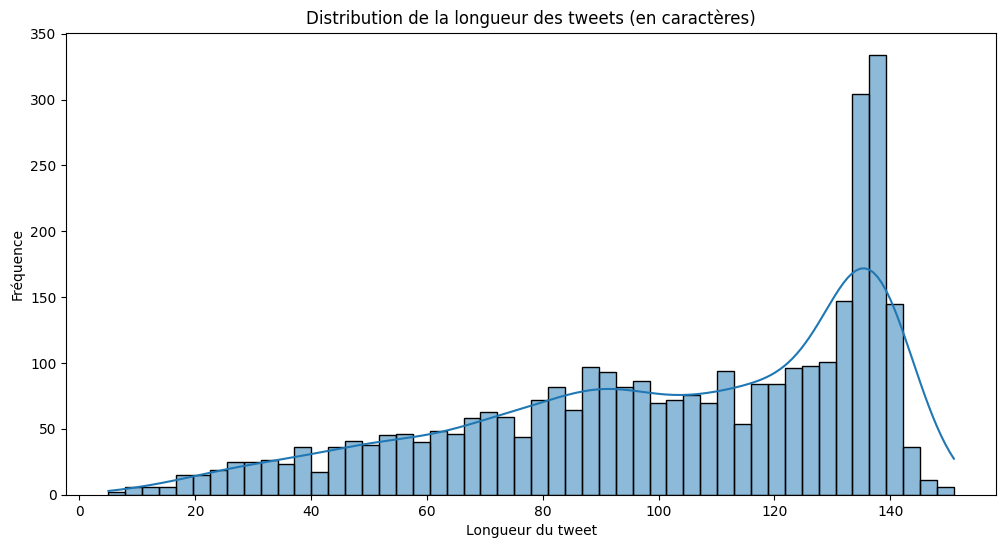

In [51]:
df_test['text_length'] = df_test['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_test['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()


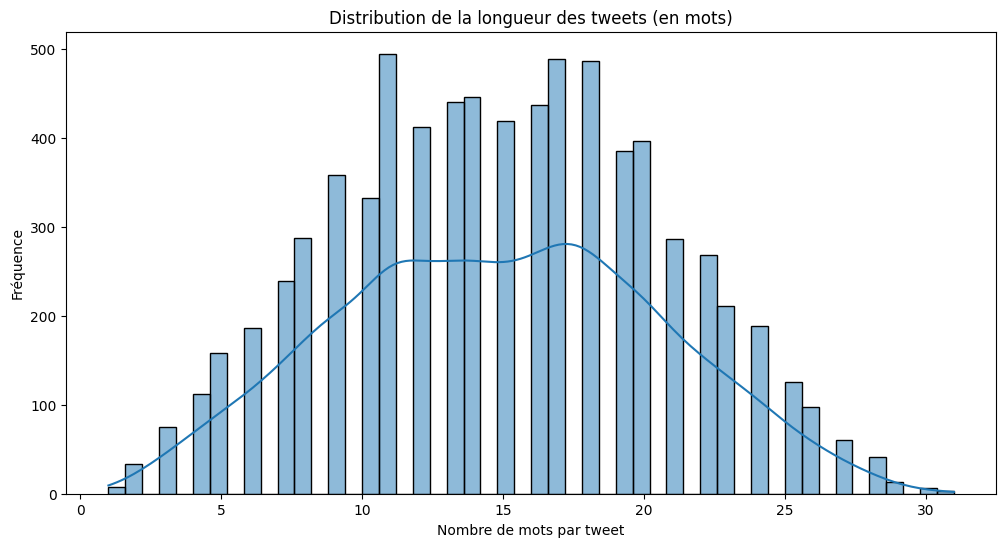

In [52]:
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en mots)')
plt.xlabel('Nombre de mots par tweet')
plt.ylabel('Fréquence')
plt.show()

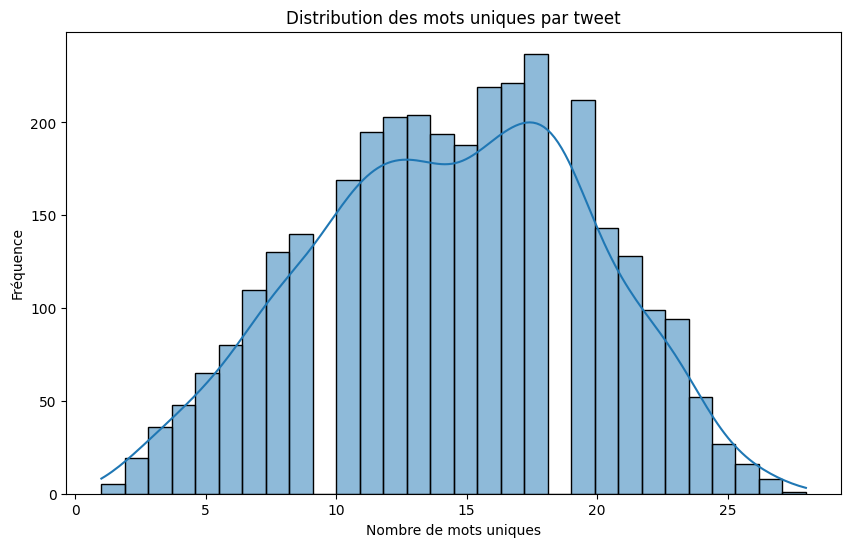

In [53]:
# Distribution des mots uniques par tweet
df_test['unique_words'] = df_test['text'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(10, 6))
sns.histplot(df_test['unique_words'], bins=30, kde=True)
plt.title('Distribution des mots uniques par tweet')
plt.xlabel('Nombre de mots uniques')
plt.ylabel('Fréquence')
plt.show()

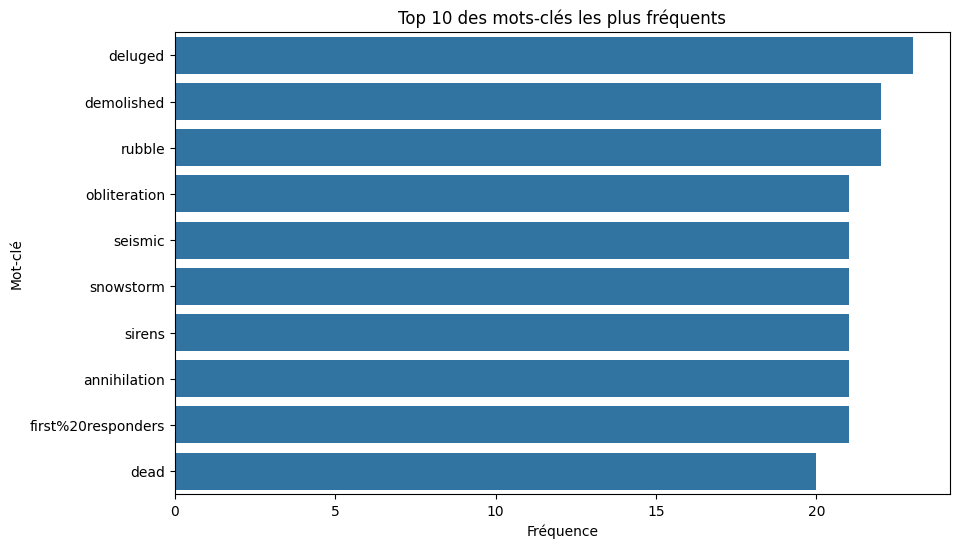

In [54]:
# Distribution des mots-clés (keywords)
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', data=df_test, order=df_test['keyword'].value_counts().iloc[:10].index)
plt.title('Top 10 des mots-clés les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Mot-clé')
plt.show()

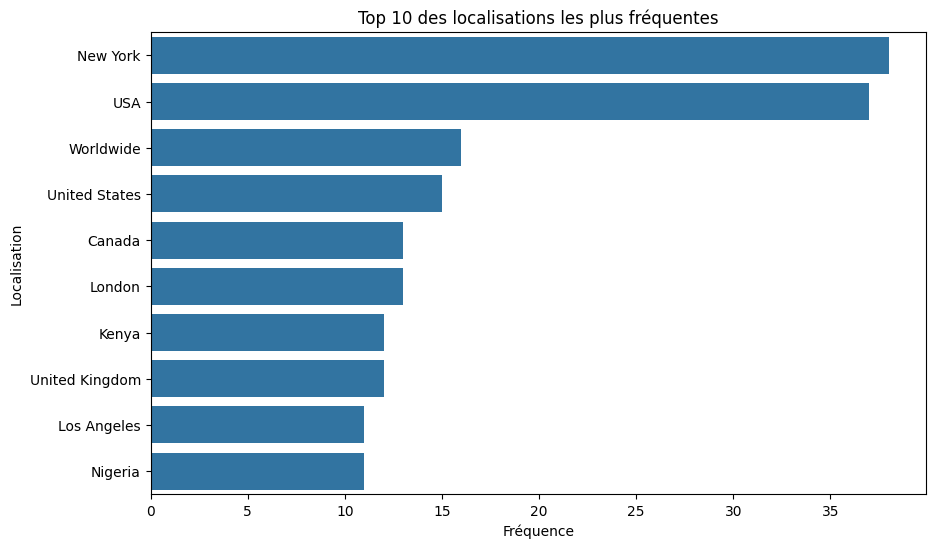

In [55]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', data=df_test, order=df_test['location'].value_counts().iloc[:10].index)
plt.title('Top 10 des localisations les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Localisation')
plt.show()

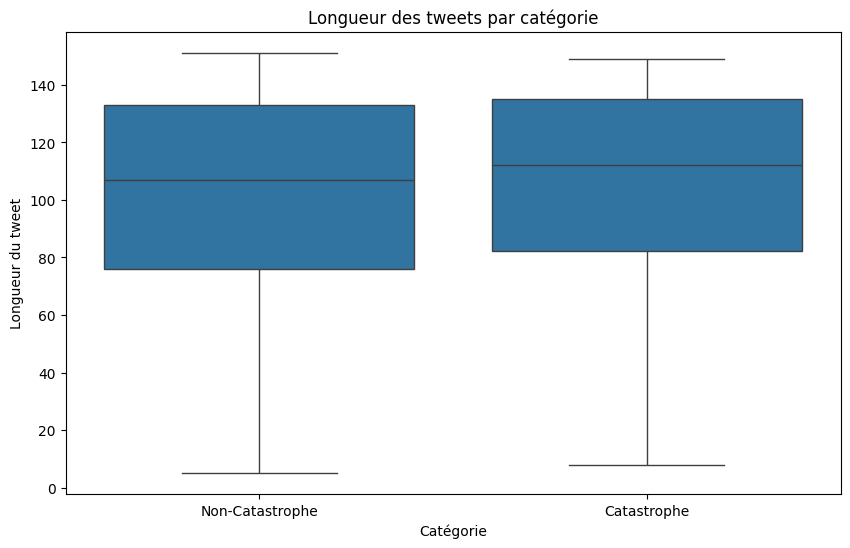

In [56]:
# Boxplot des longueurs de tweets par catégorie
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y=df_test['text'].apply(len), data=df)
plt.title('Longueur des tweets par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Longueur du tweet')
plt.xticks([0, 1], ['Non-Catastrophe', 'Catastrophe'])
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_15044\3601774211.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


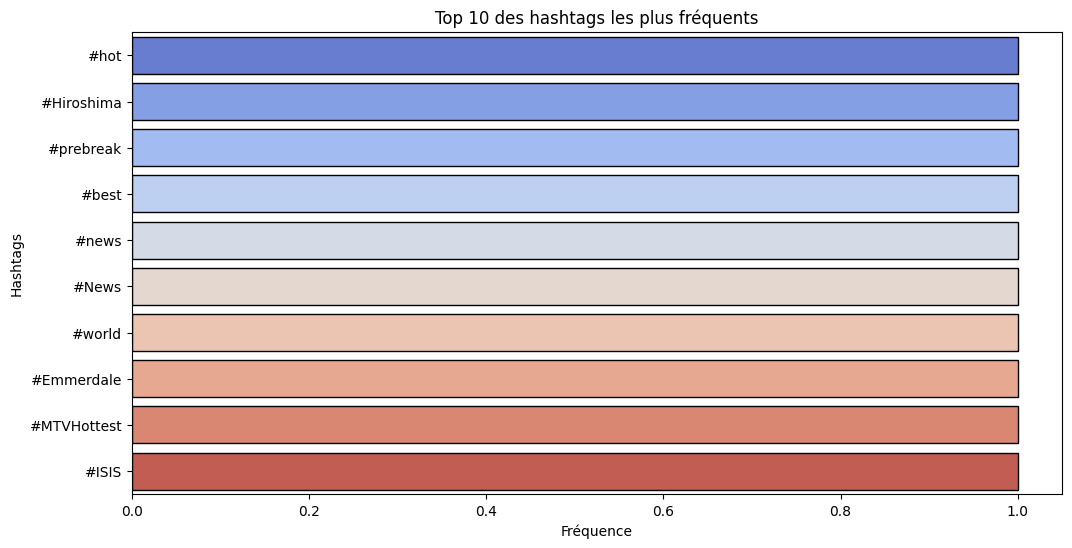

In [57]:
# Extraire les hashtags et mentions
df_test['hashtags'] = df_test['text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
# Flatten la liste des hashtags et mentions
all_hashtags = df_test['hashtags'].explode().dropna()

all_hashtags = all_hashtags[~all_hashtags.str.contains(r'^\W+$')]
hashtag_counts = all_hashtags.value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y=hashtag_counts.index, order=hashtag_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des hashtags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Hashtags')
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_15044\2872213873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')


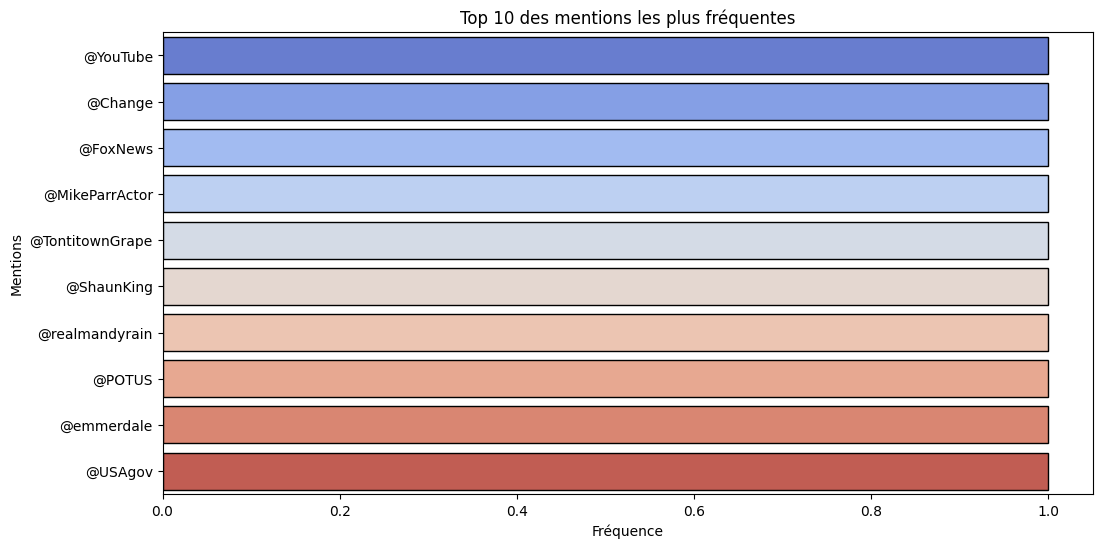

In [58]:
df_test['mentions'] = df_test['text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])
all_mentions = df_test['mentions'].explode().dropna()
all_mentions = all_mentions[all_mentions.str.contains(r'[a-zA-Z0-9]')]

mention_counts = all_mentions.value_counts()

# Mentions les plus fréquentes
plt.figure(figsize=(12, 6))
sns.countplot(y=mention_counts.index, order=mention_counts.iloc[:10].index, palette='coolwarm', edgecolor='black')
plt.title('Top 10 des mentions les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Mentions')
plt.show()

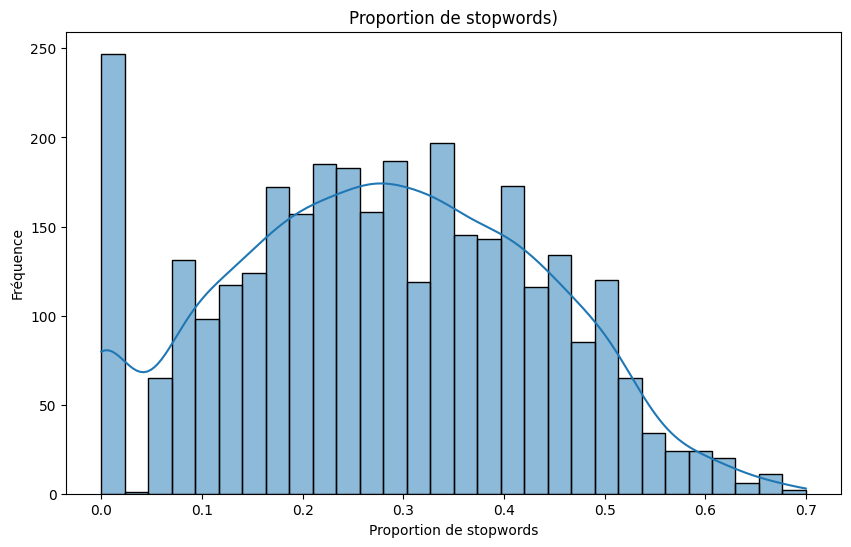

In [59]:
# Calculer le pourcentage de stopwords dans chaque tweet
df_test['stopword_percentage'] = df_test['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]) / len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_test['stopword_percentage'], bins=30, kde=True)
plt.title('Proportion de stopwords)')
plt.xlabel('Proportion de stopwords')
plt.ylabel('Fréquence')
plt.show()

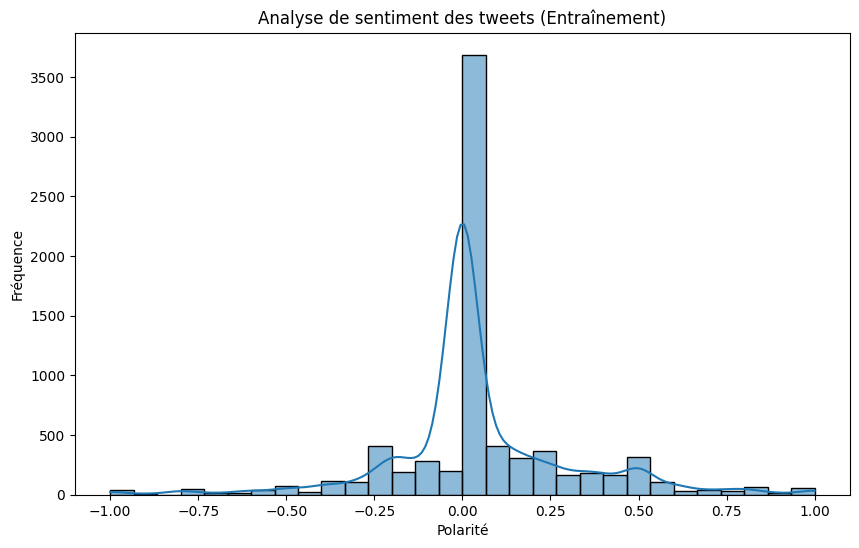

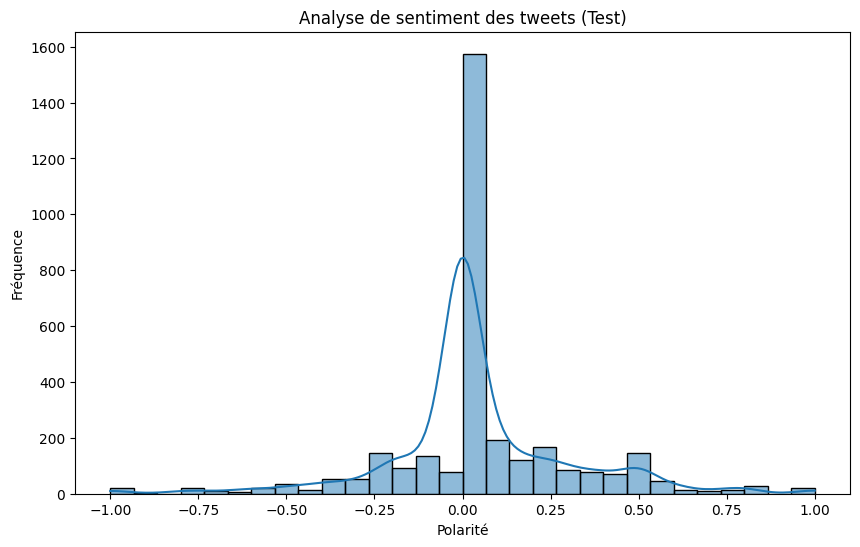

In [60]:
# Analyser le sentiment de chaque tweet
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Analyse de sentiment des tweets (Entraînement)')
plt.xlabel('Polarité')
plt.ylabel('Fréquence')
plt.show()

# Répéter pour le dataset de test
df_test['sentiment'] = df_test['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(df_test['sentiment'], bins=30, kde=True)
plt.title('Analyse de sentiment des tweets (Test)')
plt.xlabel('Polarité')
plt.ylabel('Fréquence')
plt.show()

Distribution Générale  
La majorité des tweets ont une polarité proche de 0, ce qui indique des sentiments neutres.
La distribution est légèrement asymétrique avec un léger biais vers les sentiments positifs.  
Tweets d'Entraînement
Il y a un pic très marqué autour de la polarité 0, ce qui signifie que de nombreux tweets ont un sentiment neutre.
Les sentiments négatifs (polarité < 0) sont présents mais moins fréquents.
Les sentiments positifs (polarité > 0) montrent une distribution relativement uniforme avec une légère diminution vers les sentiments très positifs.  
Tweets de Test  
La distribution des sentiments dans les tweets de test est similaire à celle des tweets d'entraînement.
La majorité des tweets de test ont également une polarité proche de 0, indiquant des sentiments neutres.
Il y a une légère tendance vers des sentiments positifs comme dans le dataset d'entraînement.  
Conclusion  
La majorité des tweets dans les deux datasets sont neutres en termes de sentiment.
Les sentiments positifs sont légèrement plus fréquents que les sentiments négatifs.
Cette distribution pourrait indiquer que les utilisateurs de Twitter, lorsqu'ils rapportent des événements liés aux catastrophes, tendent à le faire de manière neutre ou légèrement positive, peut-être en raison de la nature factuelle de ces tweets.

Creation de la pipeline de donnée avec SpaCy

Construction des fonctions / Chargement du modèle

In [61]:
# Charger le modèle
nlp = spacy.load('en_core_web_sm')

custom_stopwords = set(["oh", "please", "help", "#", "@"])
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9#@\s]', '', text)
    text = text.strip()
    return text

def spacy_pipeline(text):

    hashtags_mentions = re.findall(r'[#@]\w+', text)
    text = re.sub(r'[#@]\w+', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.text not in custom_stopwords and token.is_alpha]

    # Mettre les hashtags et mentions à la fin du traitement
    tokens.extend(hashtags_mentions)
    return ' '.join(tokens)

# Pipeline de traitement de texte
def text_pipeline(text):
    text = clean_text(text)
    return spacy_pipeline(text)

Exemple de Données de Tweets sur des Catastrophes Naturelles  
Dans cette section, nous illustrons l'application de notre pipeline de traitement de texte sur un ensemble d'exemples de tweets concernant des catastrophes naturelles. Nous commençons par nettoyer et transformer les textes, puis nous vectorisons ces textes en utilisant TF-IDF.

In [62]:
# Exemple de données de tweets
exemple_df = pd.DataFrame({
    'text': [
        'Just happened a terrible car crash #accident. Multiple vehicles involved, emergency services on the scene @citynews.',
        'There is a fire at the street market #fire @localnews. Evacuations are underway, and fire trucks are arriving.',
        'My house is flooded! Oh no! #flood @floodaid. The water level keeps rising, and we need immediate assistance.',
        'Earthquake in San Francisco! #earthquake. Buildings are shaking, people are evacuating to open spaces. @quakealert',
        'Major hurricane is approaching the city #hurricane. Heavy winds and rain expected, stay indoors and stay safe.',
        'Tornado sighted near the outskirts of town #tornado @weatheralert. Seek shelter immediately, dangerous winds reported.',
        'Wildfire spreading rapidly in the forest #wildfire @firedept. Evacuation orders issued, smoke visible from miles away.',
        'Severe thunderstorm warning in effect #storm @stormwatch. Hail and strong winds expected, stay away from windows.',
        'Landslide blocks the main highway #landslide. Road closed, detour in place, avoid the area. @trafficupdate',
        'Blizzard conditions expected overnight #blizzard. Heavy snowfall and strong winds, travel disruptions likely. @weatherchannel'
    ]
})

# Appliquer la pipeline à toutes les lignes du dataset
exemple_df['processed_text'] = exemple_df['text'].apply(text_pipeline)
print(exemple_df['processed_text'])

# Vectorisation du texte avec TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(exemple_df['processed_text'])

print("Texte original et texte prétraité :")
print(exemple_df[['text', 'processed_text']], "\n")

print("Portion de la matrice TF-IDF :")
print(X.toarray()[:5], "\n")

if __name__ == "__main__":
    print("Pipeline de traitement de texte exécutée avec succès.")

0    happen terrible car crash multiple vehicle inv...
1    fire street market evacuation underway fire tr...
2    house flood water level keeps rise need immedi...
3    earthquake san francisco building shake people...
4    major hurricane approach city heavy wind rain ...
5    tornado sight near outskirt town seek shelter ...
6    wildfire spread rapidly forest evacuation orde...
7    severe thunderstorm warning effect hail strong...
8    landslide block main highway road close detour...
9    blizzard condition expect overnight heavy snow...
Name: processed_text, dtype: object
Texte original et texte prétraité :
                                                text  \
0  Just happened a terrible car crash #accident. ...   
1  There is a fire at the street market #fire @lo...   
2  My house is flooded! Oh no! #flood @floodaid. ...   
3  Earthquake in San Francisco! #earthquake. Buil...   
4  Major hurricane is approaching the city #hurri...   
5  Tornado sighted near the outskirts of t

Explication des Résultats  
Après avoir appliqué notre pipeline de traitement de texte, nous obtenons les résultats suivants :  

Texte Original et Texte Prétraité  
Le tableau montre les tweets originaux et leurs versions prétraitées. Les tweets prétraités ont été nettoyés et transformés :  

- Les URL et balises HTML ont été supprimées.
- Le texte a été converti en minuscules.
- Les caractères spéciaux ont été supprimés, à l'exception des hashtags (#) et des mentions (@).
- Les mots ont été lemmatisés pour obtenir leur forme de base.
- Les hashtags et les mentions ont été réintégrés après le traitement.  

Portion de la Matrice TF-IDF  
La matrice TF-IDF convertit les textes prétraités en vecteurs numériques. Chaque ligne représente un tweet, et chaque colonne représente un terme unique extrait des tweets. Les valeurs de la matrice indiquent l'importance relative des termes dans chaque tweet.

Double-cliquez (ou appuyez sur Entrée) pour modifier

Double-cliquez (ou appuyez sur Entrée) pour modifier

### Adaptation de l'analyse exploratoire suite aux modifications du traitement des données textuelles.

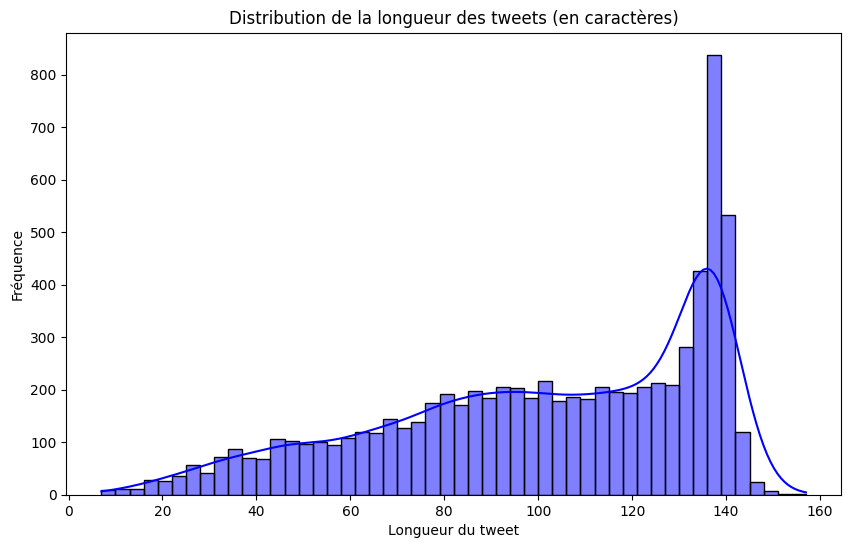

In [63]:
#verifier la longueur avant ke traitements de données
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

In [64]:
#adapter la pipeline sur le data frame de test
df['processed_text'] = df['text'].apply(text_pipeline)
print(df['processed_text'])

0                   deed reason allah forgive #earthquake
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       people receive evacuation order california #wi...
4       get send photo ruby smoke pour school #alaska ...
                              ...                        
7604    fall powerline glink tram update fire crew eva...
7605         flip m walmart bomb evacuate stay tuned blow
7606    suicide bomber kill saudi security site mosque...
7608         giant crane hold bridge collapse nearby home
7612    late home raze northern california wildfire ab...
Name: processed_text, Length: 7503, dtype: object


In [65]:
# Statistiques descriptives des longueurs de tweets prétraités
df['processed_text_length'] = df['processed_text'].apply(len)

print("Statistiques descriptives des longueurs de tweets prétraités (Test) :")
print(df['processed_text_length'].describe())

Statistiques descriptives des longueurs de tweets prétraités (Test) :
count    7503.000000
mean       57.887645
std        23.197845
min         0.000000
25%        41.000000
50%        58.000000
75%        75.000000
max       139.000000
Name: processed_text_length, dtype: float64


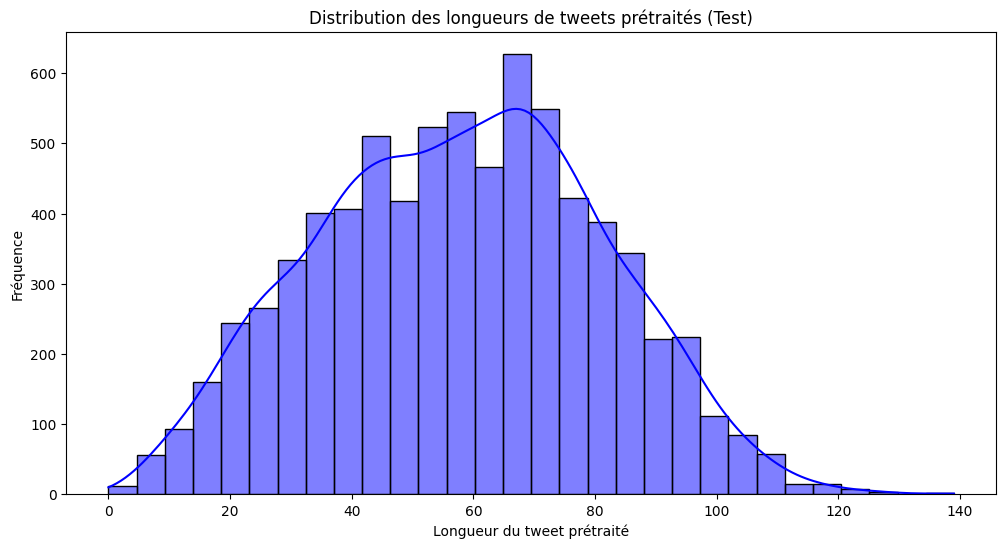

In [66]:
plt.figure(figsize=(12, 6))
sns.histplot(df['processed_text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution des longueurs de tweets prétraités (Test)')
plt.xlabel('Longueur du tweet prétraité')
plt.ylabel('Fréquence')
plt.show()

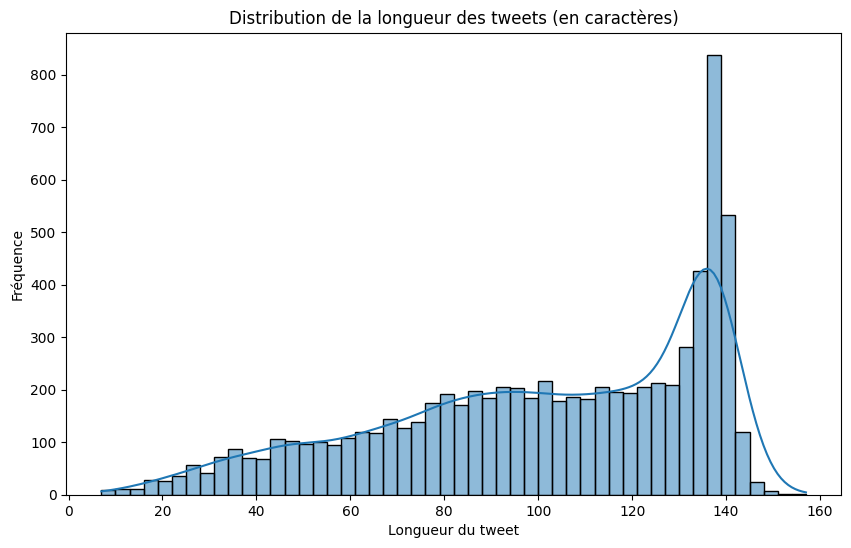

In [67]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()


### Comparaison des modèles avec GridSearch et évaluation de performances

Pour cette partie du Notebook, nous allons utiliser Gridsearch afin de comparer nos cinq modèles puis nous allons évaluer ceux-ci avec des métriques telles que F1-Score, Accuracy, Recall et Support.

Nous allons également utiliser les deux méthodes de vectorisation vue dans ce projet, à savoir TF-IDF et Bag Of Words.  
Commençons avec TF-IDF.

In [68]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['target']
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50817 stored elements and shape (7503, 5000)>
  Coords	Values
  (0, 1121)	0.5235517515716008
  (0, 3571)	0.3831131328007808
  (0, 119)	0.46536032264890204
  (0, 1679)	0.4824281566475403
  (0, 1337)	0.3603064455149898
  (1, 1675)	0.42342519403216555
  (1, 1620)	0.3040628395348004
  (1, 2948)	0.4359053612157143
  (1, 2435)	0.4895937073713566
  (1, 655)	0.5463894329492702
  (2, 3654)	0.2975326454977192
  (2, 251)	0.2513917918027112
  (2, 3949)	0.6168902621215742
  (2, 3289)	0.48529492972367
  (2, 3060)	0.24739520940800488
  (2, 1451)	0.22956682067657547
  (2, 3111)	0.24377986086624814
  (2, 1488)	0.242647464861835
  (3, 1451)	0.37393676888272187
  (3, 3111)	0.3970881036830334
  (3, 3219)	0.28892823626883907
  (3, 3574)	0.5136852347548068
  (3, 639)	0.32049082445396737
  (3, 4866)	0.5024200594256317
  (4, 4866)	0.4298553476039073
  :	:
  (7500, 2966)	0.21585597674151386
  (7500, 3676)	0.34580079781078826
  (7500, 4917)	0.2383515

Le résultat que l'on obtient indique que la vectorisation a bien été effectuée. Nous pouvons constater que nous ne voyons pas les valeurs vectorisées (avec des 0 & 1) donc expliquons ceci.  
Le résultat affiché par 'print(X)' est la représentation de la Sparse Matrix, où uniquement les valeurs non nulles sont stockées afin d'économiser de la mémoire. C'est une manière efficace de représenter des données lorsque la plupart des éléments sont des 0.  

Pour détailler un peu plus:  
- shape (7503, 5000): indique que la matrice a 7503 lignes et 5000 colonnes, correspondant respectivement aux 7503 tweets et aux 5000 termes les plus fréquents sélectionnés par 'TfidfVectorizer'.  
- 50817 stored elements: correspond au nombre total de valeurs non nulles dans la matrice.  
- Les coordonnées (par exemple 0, 1121) avec une valeur associée 0.5235517515716008 signifient que pour le premier document (ligne 0), le terme représenté par l'indice 1121 a une valeur TF-IDF de 0.5235517515716008.  

Une fois nos données vectorisées, on prépare nos ensembles de données en ensemble de test et d'entrainement en utilisant 'train_test_split()' de Scikit-Learn.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Puis on définit les hyperparamètres pour GridSearch, en voici le détail:  
**Régression Logistique:**  
- penalty spécifie la norme utilisée dans la régularisation  
- C est le paramètre de régularisation, plus il est élevé, moins la régularisation sera forte

**Decision Tree:**  
- max_depth limite la profondeur de l'arbre  
- min_sample_split est le nombre d'échantillons requis afin de diviser un noeud interne

**Random Forest:**  
- n_estimators indique le nombre d'arbre dans la forêt  
- max_features indique le nombre de caractéristiques à considérer lors de la recherche de la meilleure séparation  
- max_depth indique la profondeur maximale des arbres  

**Xgboost:**  
- n_estimators est le nombre d'arbres à construire  
- learning_rate réduit la contribution de chaque arbre par le taux de cette valeur  
- max_depth indique la profondeur maximale des arbres  

**SVM:**  
- C est le paramètre de régularisation, plus il est élevé, moins la régularisation sera forte  
- kernel est le type de noyau à utiliser dans l'algorithme ('linear' pour linéaire, 'rbf' pour fonction à base radiale, 'poly' pour polynomiale).

In [70]:
param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
}

param_grid_dtree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20]
}

param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9]
}

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

On initialise les cinq modèles

In [71]:
logreg = LogisticRegression(solver='liblinear')
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
svm = SVC()

On configure GridSearch pour chaque modèle

In [72]:
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid_dtree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

Puis on l'exécute

In [73]:
grid_search_logreg.fit(X_train, y_train)
grid_search_dtree.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)

c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    va

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

Ici on recherche les meilleurs paramètres et meilleures performances pour chaque modèle

In [74]:
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

best_params_dtree = grid_search_dtree.best_params_
best_score_dtree = grid_search_dtree.best_score_

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

Une fois que l'on a trouvé les meilleurs hyperparamètres avec GridSearch, on effectue les prédictions et évalue les modèles.

In [75]:
best_logreg = grid_search_logreg.best_estimator_
best_dtree = grid_search_dtree.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_svm = grid_search_svm.best_estimator_

y_pred_logreg = best_logreg.predict(X_test)
y_pred_dtree = best_dtree.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

Puis on affiche les résultats

In [76]:
print("Best parameters for Logistic Regression:", best_params_logreg)
print("Best score for Logistic Regression:", best_score_logreg)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))
confusion_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix for Logistic Regression:\n", confusion_logreg)

print("Best parameters for Decision Tree:", best_params_dtree)
print("Best score for Decision Tree:", best_score_dtree)
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dtree))
confusion_dtree = confusion_matrix(y_test, y_pred_dtree)
print("Confusion Matrix for Decision Tree:\n", confusion_dtree)

print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
confusion_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:\n", confusion_rf)

print("Best parameters for XGBoost:", best_params_xgb)
print("Best score for XGBoost:", best_score_xgb)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost:\n", confusion_xgb)

print("Best parameters for SVM:", best_params_svm)
print("Best score for SVM:", best_score_svm)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
confusion_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix for SVM:\n", confusion_svm)

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best score for Logistic Regression: 0.7975693866222593
Logistic Regression Test Accuracy: 0.7954696868754164
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.81      0.66      0.73       627

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.78      1501
weighted avg       0.80      0.80      0.79      1501

Confusion Matrix for Logistic Regression:
 [[780  94]
 [213 414]]
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 20}
Best score for Decision Tree: 0.7302568692756036
Decision Tree Test Accuracy: 0.7108594270486343
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       874
           1       0.65      0.67      0.66       627

    accu

### Interprétation des résultats avec la méthode TF-IDF

Nous allons faire une interprétation par modèle:  

**Régression Logistique:**  
- Meilleurs paramètres: 'C': 1, 'penalty': 'l2'  
- Meilleur score (cross-validation) : 0.7976  
- Accuracy 0.7955  
- Matrice de Confusion:  
        [[780  94]  
        [213 414]]

Pour le modèle de Régression Logistique nous avons donc avec les paramètres C et penalty une Accuracy à presque 0.80, ce qui indique que le modèle prédit correctement environ 79,55% des exemples. Le Recall pour la classe 1 est de 0.66 donc le modèle identifie correctement 66% des exemples positifs. Le F1-score global est de 0.79, un compromis entre Accuracy et Recall.  

Pour la Matrice de Confusion:  
780 vrais négatifs (TN) : exemples correctement prédits comme négatifs.
414 vrais positifs (TP) : exemples correctement prédits comme positifs.
213 faux négatifs (FN) : exemples réels positifs incorrectement prédits comme négatifs.
94 faux positifs (FP) : exemples réels négatifs incorrectement prédits comme positifs.  


**Decision Tree:**  
- Meilleurs paramètres : 'max_depth': None, 'min_samples_split': 20  
- Meilleur score (cross-validation) : 0.7369  
- Accuracy 0.7242  
- Matrice de Confusion:  
        [[651  223]  
        [191 436]]

Pour le modèle de Decision Tree nous avons donc avec les paramètres max_depth à None et un min_samples_split à 20 une Accuracy de 0.7242 ce qui indique que le modèle prédit correctement environ 72.42% des exemples. Le recall pour la classe 1 est de 0.70, ce qui signifie que le modèle identifie correctement 70% des exemples positifs. Le F1-score global est de 0.73, indiquant une performance moyenne du modèle.

Pour la Matrice de Confusion:  
651 vrais négatifs (TN) : exemples correctement prédits comme négatifs.  
436 vrais positifs (TP) : exemples correctement prédits comme positifs.  
191 faux négatifs (FN) : exemples réels positifs incorrectement prédits comme négatifs.  
223 faux positifs (FP) : exemples réels négatifs incorrectement prédits comme positifs.  

**Random Forest:**  
- Meilleurs paramètres : 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100  
- Meilleur score (cross-validation) : 0.7921  
- Accuracy 0.7821  
- Matrice de Confusion:  
        [[780  94]  
        [233 394]]

Pour le modèle de Random Forest nous avons donc avec les pramètres max_depth à None, max_features à log2 et n_estimators à 100 une Accuracy à 0.7821 ce qui indique que le modèle prédit correctement environ 78,21% des exemples. Le Recall pour la classe 1 est de 0.63 ce qui signifie que le modèle identifie correctement 63% des exemples positifs. Le F1-Score global est de 0.78, montrant une performance équilibrée du modèle.  

Pour la Matrice de Confusion:  
780 vrais négatifs (TN) : exemples correctement prédits comme négatifs.  
394 vrais positifs (TP) : exemples correctement prédits comme positifs.  
233 faux négatifs (FN) : exemples réels positifs incorrectement prédits comme négatifs.  
94 faux positifs (FP) : exemples réels négatifs incorrectement prédits comme positifs.  

**Xgboost:**  
- Meilleurs paramètres : 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500  
- Meilleur score (cross-validation) : 0.7819  
- Accuracy 0.7615  
- Matrice de Confusion:  
        [[752 122]
        [236 391]]

Pour le modèle Xgboost nous avons donc avec les paramètres learning_rate à 0,1 max_depth à 6 et n_estimators à 500 une Accuracy à 0.7615 ce qui indique que le modèle prédit correctement environ 76,15% des exemples. Le Recall pour la classe 1 est de 0.62 ce qui sigifie que le modèle identifie correctement 62% des exemples positifs. Le F1-Score global est de 0.76, montrant une performance modérée du modèle.  

Pour la Matrice de Confusion:  
752 vrais négatifs (TN) : exemples correctement prédits comme négatifs.  
391 vrais positifs (TP) : exemples correctement prédits comme positifs.  
236 faux négatifs (FN) : exemples réels positifs incorrectement prédits comme négatifs.  
122 faux positifs (FP) : exemples réels négatifs incorrectement prédits comme positifs.  

**SVM:**  
- Meilleurs paramètres : 'C': 1, 'kernel': 'rbf'  
- Meilleur score (cross-validation) : 0.7966  
- Accuracy 0.7968  
- Matrice de Confusion:  
        [[794  80]
        [225 402]]

Pour le modèle SVM nous avons donc avec les paramètres C à 1 et rbf pour le kernel une Accuracy à 0.7968 ce qui indique que le modèle prédit correctement environ 79,68% des exemples. Le Recall pour la classe 1 est de 0.64, ce qui signifie que le modèle identifie correctement 64% des exemples positifs. Le F1-score global est de 0.80, montrant une bonne performance globale du modèle.  

Pour la Matrice de Confusion:  
794 vrais négatifs (TN) : exemples correctement prédits comme négatifs.  
402 vrais positifs (TP) : exemples correctement prédits comme positifs.  
225 faux négatifs (FN) : exemples réels positifs incorrectement prédits comme négatifs.  
80 faux positifs (FP) : exemples réels négatifs incorrectement prédits comme positifs.  

En termes de performance générale sur l'ensemble de test, le modèle SVM semble avoir la meilleure accuracy (0.7968) et un bon F1-score (0.80), bien qu'il soit légèrement déséquilibré en termes de recall entre les classes. La Logistic Regression présente également de bonnes performances globales avec un F1-score de 0.79. Les modèles Decision Tree, Random Forest et XGBoost montrent des performances légèrement inférieures, avec des F1-scores allant de 0.69 à 0.73. 

semble avoir la meilleure accuracy (0.7968) et un bon F1-score (0.80), bien qu'il soit légèrement déséquilibré en termes de recall entre les classes. La Logistic Regression présente également de bonnes performances globales avec un F1-score de 0.79. Les modèles Decision Tree, Random Forest et XGBoost montrent des performances légèrement inférieures, avec des F1-scores allant de 0.69 à 0.73. 

Nous allons maintenant optimiser la métrique F1-Score

Tout d'abord on identifie les caractéristiques numériques et catégorielles


In [89]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()


# X_train = pd.DataFrame(X_train, columns=numerical_features + categorical_features)
# X_test = pd.DataFrame(X_test, columns=numerical_features + categorical_features)

# X_train = X_train.reshape(-1, 1)
# X_test = X_test.reshape(-1, 1)

X_train_df = pd.DataFrame(X_train, columns=numerical_features + categorical_features)
X_test_df = pd.DataFrame(X_test, columns=numerical_features + categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('cat', OneHotEncoder(), categorical_features) 
    ])

TypeError: 'coo_matrix' object is not subscriptable

Pour le modèle de Régression Logistique

In [ ]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [78]:
# Tout d'abord on définit les hyperparamètres à tester
param_grid_logreg = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

In [79]:
# En suite on crée une fonction de score basée sur le F1-score
f1_scorer = make_scorer(f1_score)

In [81]:
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid_logreg, scoring=f1_scorer, cv=5)

In [ ]:
grid_search_logreg.fit(X_train_df, y_train)

In [ ]:
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

In [ ]:
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_df)
f1_test_score_logreg = f1_score(y_test, y_pred_logreg)

In [ ]:
print("Logistic Regression:")
print("Best parameters:", grid_search_logreg.best_params_)
print("Best F1-score (CV):", grid_search_logreg.best_score_)
print("F1-score on Test Set:", f1_test_score_logreg)
print(classification_report(y_test, y_pred_logreg))

Pour le Decision Tree

In [90]:
param_grid_dtree = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

In [91]:
# En suite on crée une fonction de score basée sur le F1-score
f1_scorer = make_scorer(f1_score)

In [92]:
dtree = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])

In [93]:
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid_dtree, scoring=f1_scorer, cv=5)

In [ ]:
grid_search_dtree.fit(X_train, y_train)

In [ ]:
best_params_dtree = grid_search_dtree.best_params_
best_score_dtree = grid_search_dtree.best_score_

In [ ]:
best_dtree = grid_search_dtree.best_estimator_
y_pred_dtree = best_dtree.predict(X_test)
f1_test_score_dtree = f1_score(y_test, y_pred_dtree)

In [ ]:
print("Decision Tree:")
print("Best parameters:", grid_search_dtree.best_params_)
print("Best F1-score (CV):", grid_search_dtree.best_score_)
print("F1-score on Test Set:", f1_test_score_dtree)
print(classification_report(y_test, y_pred_dtree))

Pour le Random Forest

In [ ]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

In [ ]:
# En suite on crée une fonction de score basée sur le F1-score
f1_scorer = make_scorer(f1_score)

In [ ]:
rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])

In [ ]:
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=f1_scorer, cv=5)

In [ ]:
grid_search_rf.fit(X_train, y_train)

In [ ]:
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

In [ ]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
f1_test_score_rf = f1_score(y_test, y_pred_rf)

In [ ]:
print("Random Forest:")
print("Best parameters:", grid_search_rf.best_params_)
print("Best F1-score (CV):", grid_search_rf.best_score_)
print("F1-score on Test Set:", f1_test_score_rf)
print(classification_report(y_test, y_pred_rf))

Pour Xgboost

In [ ]:
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [6, 8, 10]
}

In [ ]:
# En suite on crée une fonction de score basée sur le F1-score
f1_scorer = make_scorer(f1_score)

In [ ]:
xgb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier())])

In [ ]:
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring=f1_scorer, cv=5)

In [ ]:
grid_search_xgb.fit(X_train, y_train)

In [ ]:
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

In [ ]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
f1_test_score_xgb = f1_score(y_test, y_pred_xgb)

In [ ]:
print("XGBoost:")
print("Best parameters:", grid_search_xgb.best_params_)
print("Best F1-score (CV):", grid_search_xgb.best_score_)
print("F1-score on Test Set:", f1_test_score_xgb)
print(classification_report(y_test, y_pred_xgb))

Pour SVM

In [ ]:
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

In [ ]:
# En suite on crée une fonction de score basée sur le F1-score
f1_scorer = make_scorer(f1_score)

In [ ]:
svm = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC())])

In [ ]:
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring=f1_scorer, cv=5)

In [ ]:
grid_search_svm.fit(X_train, y_train)

In [ ]:
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

In [ ]:
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
f1_test_score_svm = f1_score(y_test, y_pred_svm)

In [ ]:
print("SVM:")
print("Best parameters:", grid_search_svm.best_params_)
print("Best F1-score (CV):", grid_search_svm.best_score_)
print("F1-score on Test Set:", f1_test_score_svm)
print(classification_report(y_test, y_pred_svm))

Avec méthode Bag of Words

In [95]:
# Appliquer le prétraitement au dataset d'entraînement
df['processed_text'] = df['text'].apply(text_pipeline)

# Séparation des données
X = df['processed_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Pipeline avec Bag of Words et GridSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

In [97]:
# Paramètres pour GridSearch
parameters = [
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [10, 50, None]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 50, None]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6]
    },
    {
        'vectorizer__max_features': (500, 1000, 1500),
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

In [98]:
# GridSearch
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


c:\wamp64\www\eye-of-emergency\emergency-env\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))},
                         {'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth':...
                          'classifier__max_depth': [3, 6],
                          'classifier__n_estimators': [100, 200],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'vectorizer__max_features': (500, 1000, 1500),
                          'vectorizer__ngram_range': ((1, 1), (1, 2))}],
             scoring='accuracy', verbose=2)

In [ ]:
# Meilleurs paramètres et résultats
print("Best parameters set:")
print(grid_search.best_params_)
print("Best score:")
print(grid_search.best_score_)

Best parameters set:
{'classifier': SVC(), 'classifier__C': 1, 'classifier__kernel': 'rbf', 'vectorizer__max_features': 1500, 'vectorizer__ngram_range': (1, 1)}
Best score:
0.7987328615043021


In [ ]:
# Prédictions et rapport de classification
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.82      0.65      0.73       627

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.78      1501
weighted avg       0.80      0.80      0.79      1501



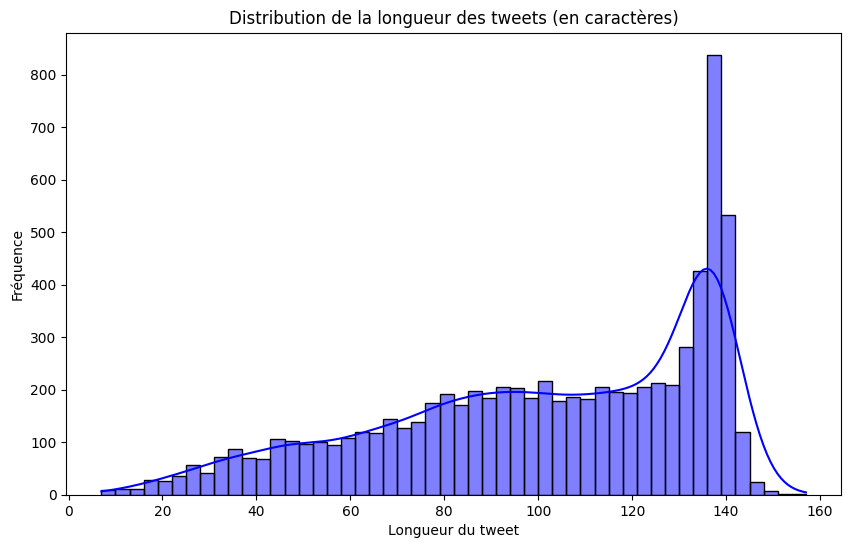

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution de la longueur des tweets (en caractères)')
plt.xlabel('Longueur du tweet')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Appliquer le modèle optimal sur le dataset de test
df_test = pd.read_csv('./csv/test_tweets.csv')
df_test['processed_text'] = df_test['text'].apply(text_pipeline)
X_test_final = df_test['processed_text']
y_test_pred = best_model.predict(X_test_final)

In [ ]:
# Ajouter les prédictions au dataset de test
df_test['predictions'] = y_test_pred
print(df_test[['text', 'predictions']])

                                                   text  predictions
0                    Just happened a terrible car crash            1
1     Heard about #earthquake is different cities, s...            1
2     there is a forest fire at spot pond, geese are...            1
3              Apocalypse lighting. #Spokane #wildfires            0
4         Typhoon Soudelor kills 28 in China and Taiwan            1
...                                                 ...          ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...            1
3259  Storm in RI worse than last hurricane. My city...            1
3260  Green Line derailment in Chicago http://t.co/U...            1
3261  MEG issues Hazardous Weather Outlook (HWO) htt...            1
3262  #CityofCalgary has activated its Municipal Eme...            0

[3263 rows x 2 columns]


## Conclusion

Après avoir évalué plusieurs modèles de classification pour l'analyse des tweets en utilisant la méthode TF-IDF, plusieurs observations significatives peuvent être faites.  

En termes de performances, le modèle SVM (Support Vector Machine) se démarque avec une accuracy de 0.7968 sur l'ensemble de test, dépassant légèrement les autres modèles évalués. De plus, le SVM présente un bon F1-score global de 0.80, indiquant sa capacité à maintenir un équilibre entre précision et rappel pour les deux classes cibles.  

Toutefois, il est important de noter que le SVM montre un léger déséquilibre en termes de rappel entre les classes, ce qui peut nécessiter une prise en compte particulière selon le contexte d'application spécifique.  

En conséquence, en raison de ses performances globalement robustes et de sa capacité à généraliser efficacement sur de nouveaux tweets, le SVM avec TF-IDF est recommandé comme le modèle optimal pour la classification des tweets dans cette comparaison. Cependant, d'autres modèles comme la régression logistique peuvent également être considérés en fonction d'autres critères tels que l'interprétabilité ou les exigences en termes de temps de calcul.  

En conclusion, le choix du SVM avec TF-IDF pour la classification des tweets offre une solution efficace et performante, adaptée aux besoins de précision et de généralisation dans des applications réelles.  